# Flavours of Physics: Finding $\tau \rightarrow 3 \mu$

https://www.kaggle.com/competitions/flavours-of-physics

https://storage.googleapis.com/kaggle-competitions/kaggle/4488/media/lhcb_description_official.pdf

https://arxiv.org/pdf/1409.8548.pdf

<div> <img src="fig/lhcb_trimuon_decay.png" alt="Drawing" style="width: 400px;"/></div>

https://muon.wordpress.com/2014/10/04/lhcb-searches-for-lfv-in-tau-decays/

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from fitter import Fitter

from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import RFE

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesClassifier  


## Import data

In [2]:
def train_corr(data): #matriz de correlación
    correlation = data.corr()
    sns.heatmap(correlation, annot=True, cbar=True, cmap="RdYlGn")

In [3]:
train = pd.read_csv("datasets/training.csv") #filepath
test = pd.read_csv("datasets/test.csv") #filepath

##  General information (train data)

In [4]:
#train.info()
train.head()

,id,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,...,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
0,18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,...,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,-99,0,1866.300049,0.277559
1,5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,...,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,-99,0,1727.095947,0.225924
2,11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,...,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,-99,0,1898.588013,0.368630
3,15173787,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,...,16909.515625,9141.426758,3.087461,3.218034,2.375592,137,-99,0,1840.410034,0.246045
4,1102544,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,...,97612.804688,47118.785156,4.632295,4.711155,4.296878,477,-99,0,1899.793945,0.222060


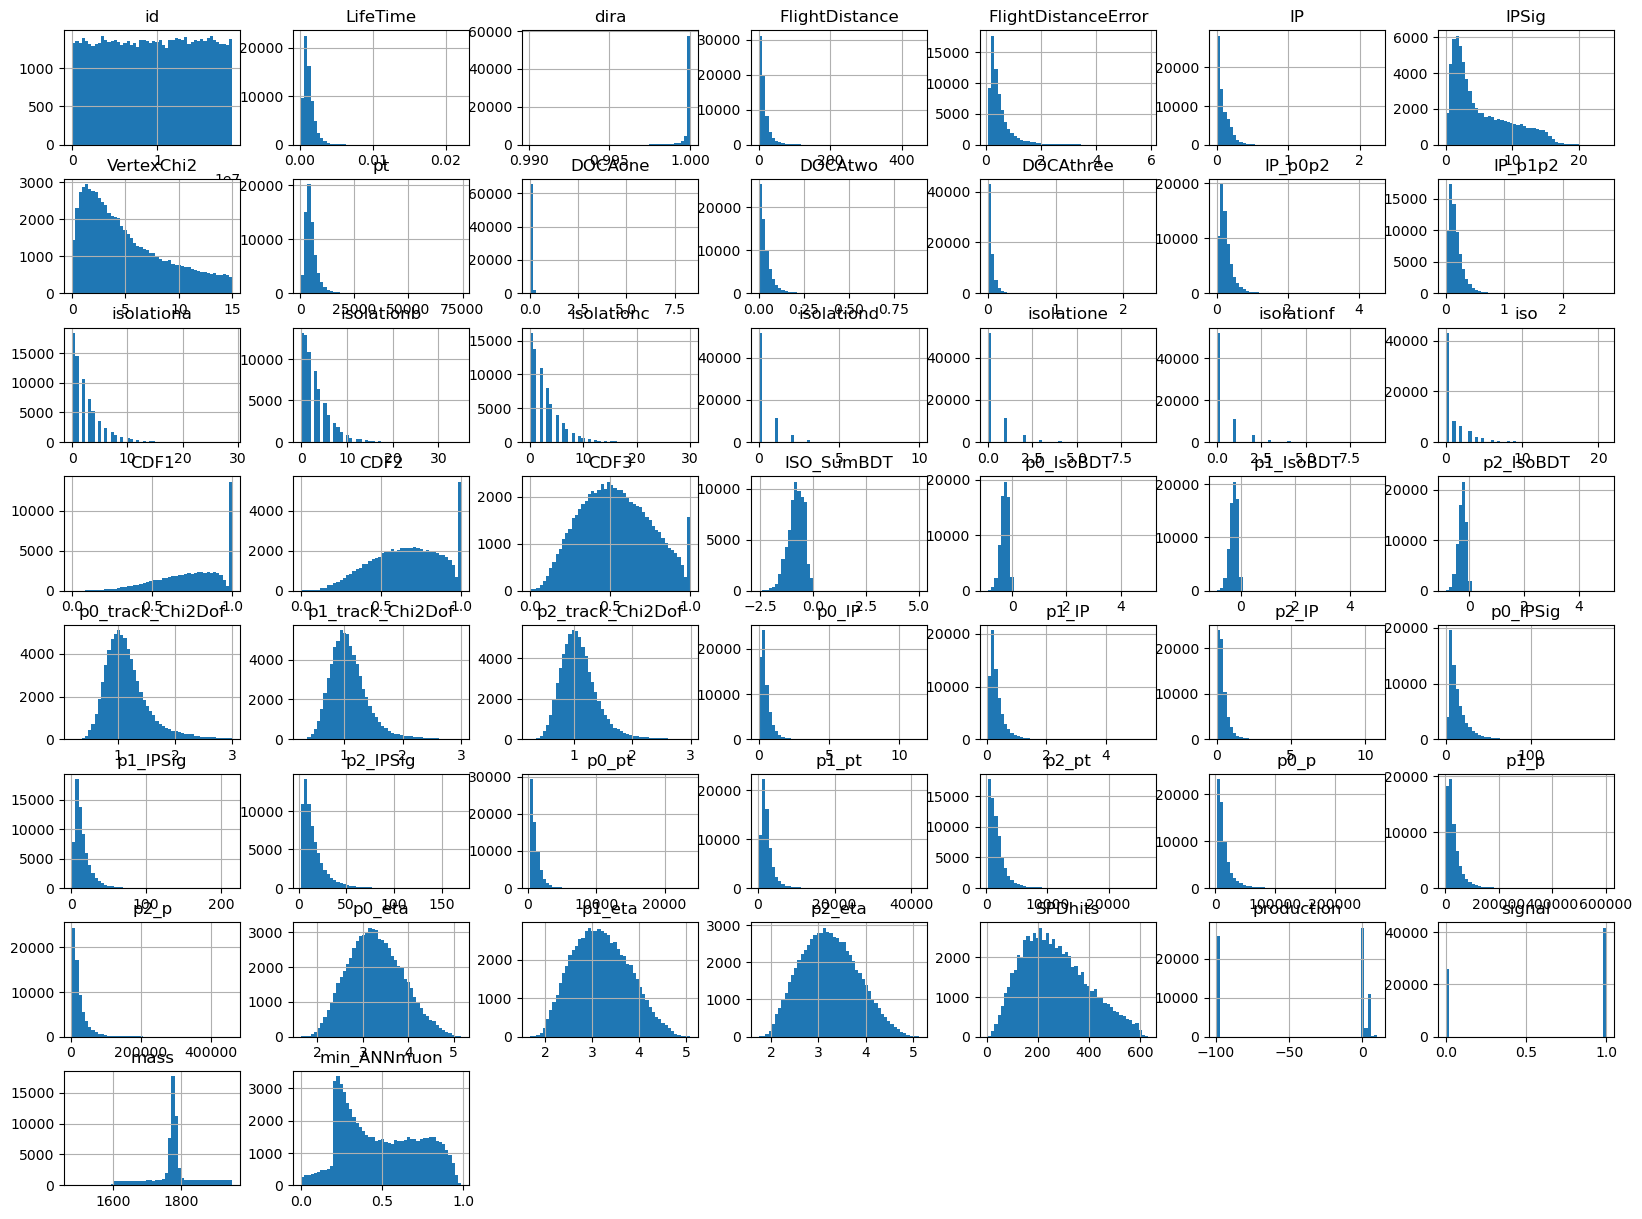

In [5]:
train.hist(bins=50, figsize=(20,15))
plt.show()

## Attributes

| Variable	| Definition |
| --- | --- |
| $\tau$ | --- |
| FlightDistance | Distance between τ and PV  |
| FlightDistanceError | Error on FlightDistance | | 
| mass | τ candidate invariant mass  | 
| LifeTime | Life time of tau candidate  |
| IP | Impact Parameter of tau candidate  |
| IPSig | **Significance of Impact Parameter**  |
| VertexChi2 | **χ2 of tau vertex**  |
| dira | **Cosine of the angle between the τ momentum and line between PV and tau vertex** |
| pt | transverse momentum of tau  | 
| Decay 3 $\mu$  |   |
| DOCAone - Distance of Closest Approach between p0 and p1  | | 
| IP p0p2 - Impact parameter of the p0 and p2 pair (3)| |  
| iso - Track isolation variable | |
| CDF1 - Cone isolation variable (3) | |
| ISO SumBDT - Track isolation variable | |
| p1 IsoBDT - Track isolation variable (3) | |
| p0 track Chi2Dof - Quality of p0 muon track (3) | |
| p0 pt | Transverse momentum of p0 muon (3)  | 
| p0 p | Momentum of p0 muon (3)  |
| p0 eta | Pseudorapidity of p0 muon  | 
| p0 IP - Impact parameter of p0 muon (3)| |
| p0 IPSig - Impact Parameter Significance of p0 muon (3)| |
| SPDhits- Number of hits in the SPD detector | |

## Signal y background

Signal: $\tau^- \rightarrow \mu^- \mu^-\mu^+$ 

Background 1: $D_s \rightarrow \eta (\mu^-\mu^+\gamma)\mu^-\nu_{\mu}$ 

Background 2: $D^+ \rightarrow K^-\pi^+\pi^+$ 

|   |    |
|---| ---|
| $m_{\tau}$ | 1776.86 MeV/c²|
| $m_{\mu}$  | 105.66 MeV/c²) |
| $m_{K\pm}$ |  493.68 MeV/c²|
| $m_{\pi\pm}$ | 139.57 MeV/c² |
|   | |

# Divir en 3 subsets según sus características físicas:

1. Inicial (tau)
2. Decaimiento (muon)
3. Información del detector (detector)

In [6]:
subset_mu = train[["p0_p", "p1_p", "p2_p", "p0_pt" , "p1_pt" , "p2_pt", "p0_eta" , "p1_eta","p2_eta","signal"  ]]
subset_detector = train.drop(["LifeTime", "FlightDistance", "dira", "mass" , "pt" , "IP", "IPSig" , "VertexChi2","signal", "p0_p", "p1_p", "p2_p", "p0_pt" , "p1_pt" , "p2_pt", "p0_eta" , "p1_eta","p2_eta" ], axis=1)
subset_tau =train[["LifeTime", "FlightDistance", "dira", "mass" , "pt" , "IP", "IPSig" , "VertexChi2","signal" ]]


In [7]:
#This is a labelled dataset (the label ‘signal’ being ‘1’ for signal events, ‘0’ for background events) 
# to train the classifier. Signal events have been simulated, while background events are real data.

señal = train[(train["signal"]==1)]
background = train[(train["signal"]==0)]
print("Señal=",señal.shape[0])
print("Background=",background.shape[0])

Señal= 41674
Background= 25879


## Leptón $\tau$

<AxesSubplot: xlabel='VertexChi2', ylabel='Count'>

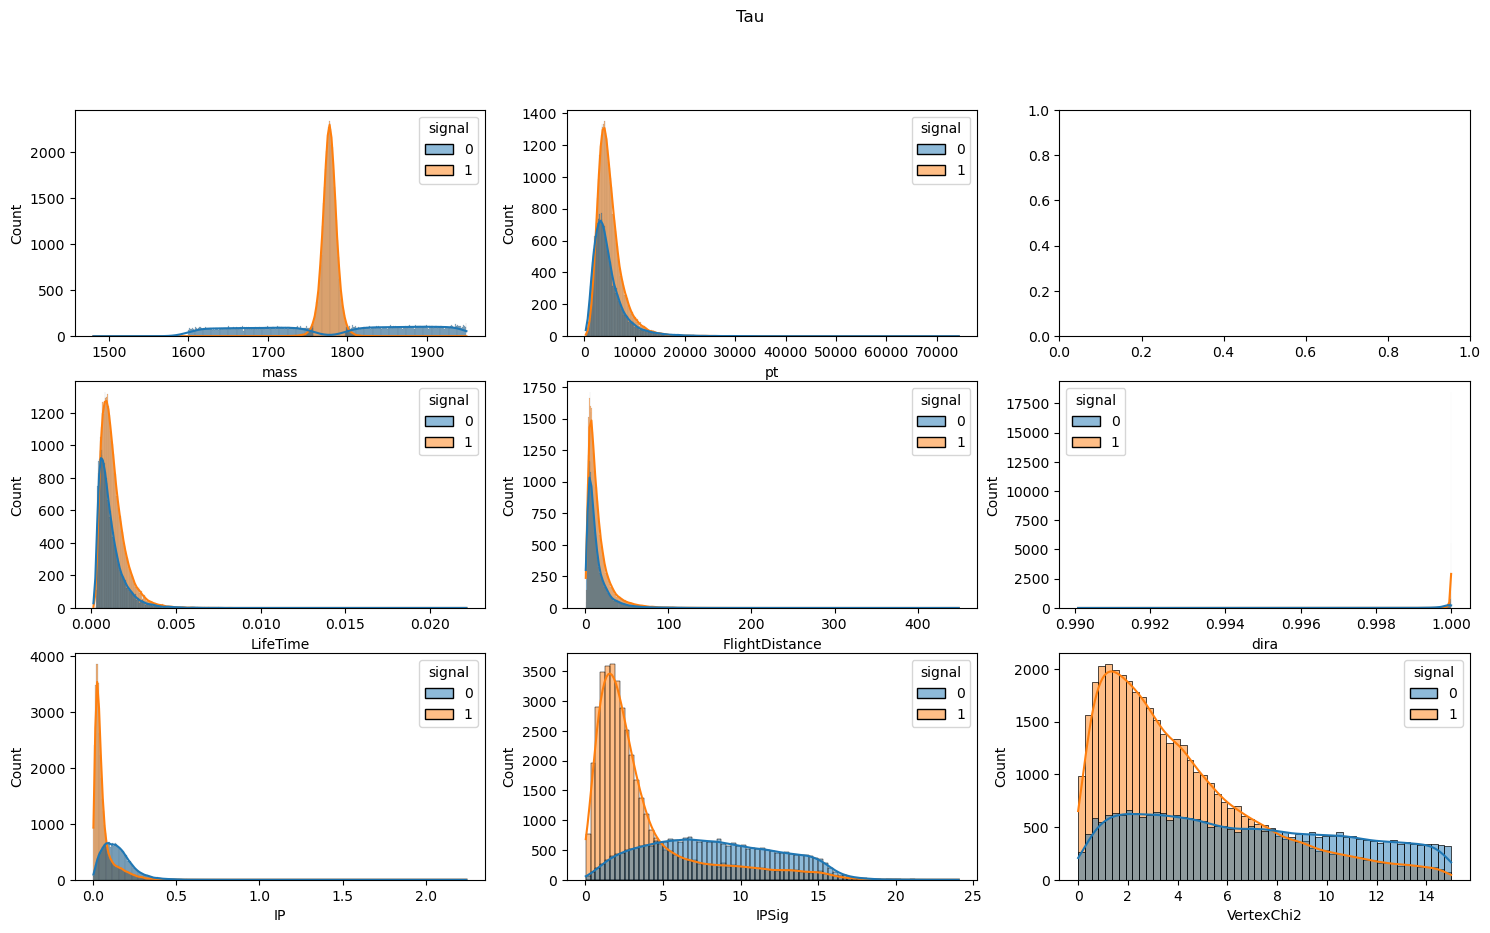

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(18, 10))
fig.suptitle('Tau')
sns.histplot(data=train, x="mass",kde=True, hue = "signal", ax=axs[0, 0])
sns.histplot(data=train, x="pt",kde=True, hue = "signal", ax=axs[0, 1])
sns.histplot(data=train, x="LifeTime",kde=True, hue = "signal", ax=axs[1, 0])
sns.histplot(data=train, x="FlightDistance",kde=True, hue = "signal", ax=axs[1, 1])
sns.histplot(data=train, x="dira",kde=True, hue = "signal", ax=axs[1, 2] )
sns.histplot(data=train, x="IP",kde=True, hue = "signal", ax=axs[2, 0])
sns.histplot(data=train, x="IPSig",kde=True, hue = "signal", ax=axs[2, 1])
sns.histplot(data=train, x="VertexChi2",kde=True, hue = "signal", ax=axs[2, 2])

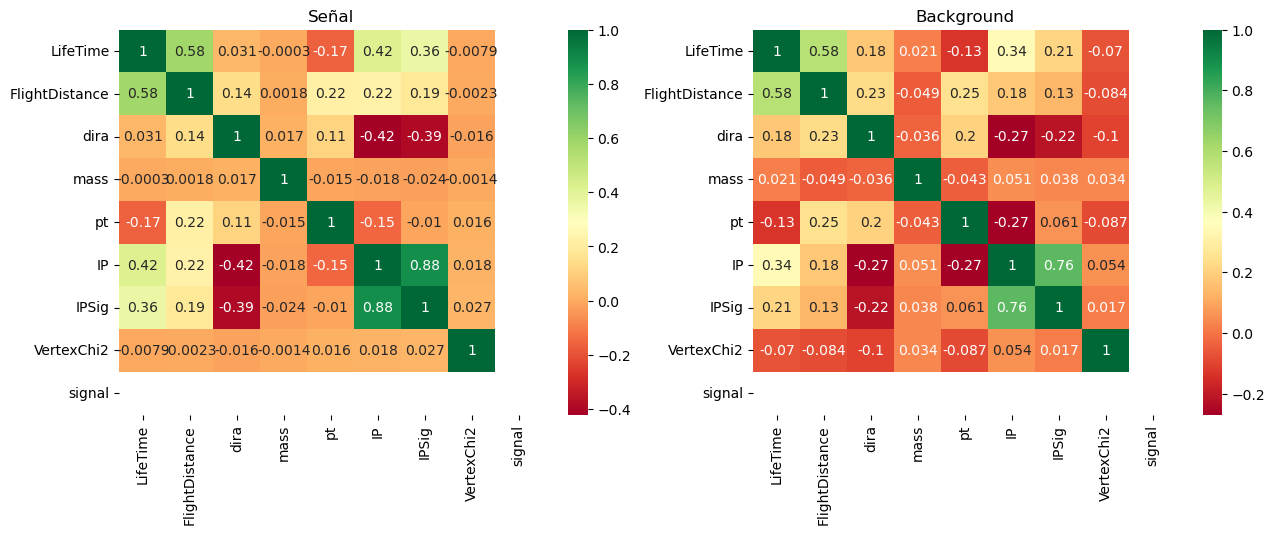

In [9]:
subset_tau_señal =señal[["LifeTime", "FlightDistance", "dira", "mass" , "pt" , "IP", "IPSig" , "VertexChi2","signal" ]] 
subset_tau_background = background[["LifeTime", "FlightDistance", "dira", "mass" , "pt" , "IP", "IPSig" , "VertexChi2","signal" ]]
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Señal")
train_corr(subset_tau_señal)
plt.subplot(1,2,2)
plt.title("Background")
train_corr(subset_tau_background)

## 3 muons

<AxesSubplot: xlabel='p2_eta', ylabel='Count'>

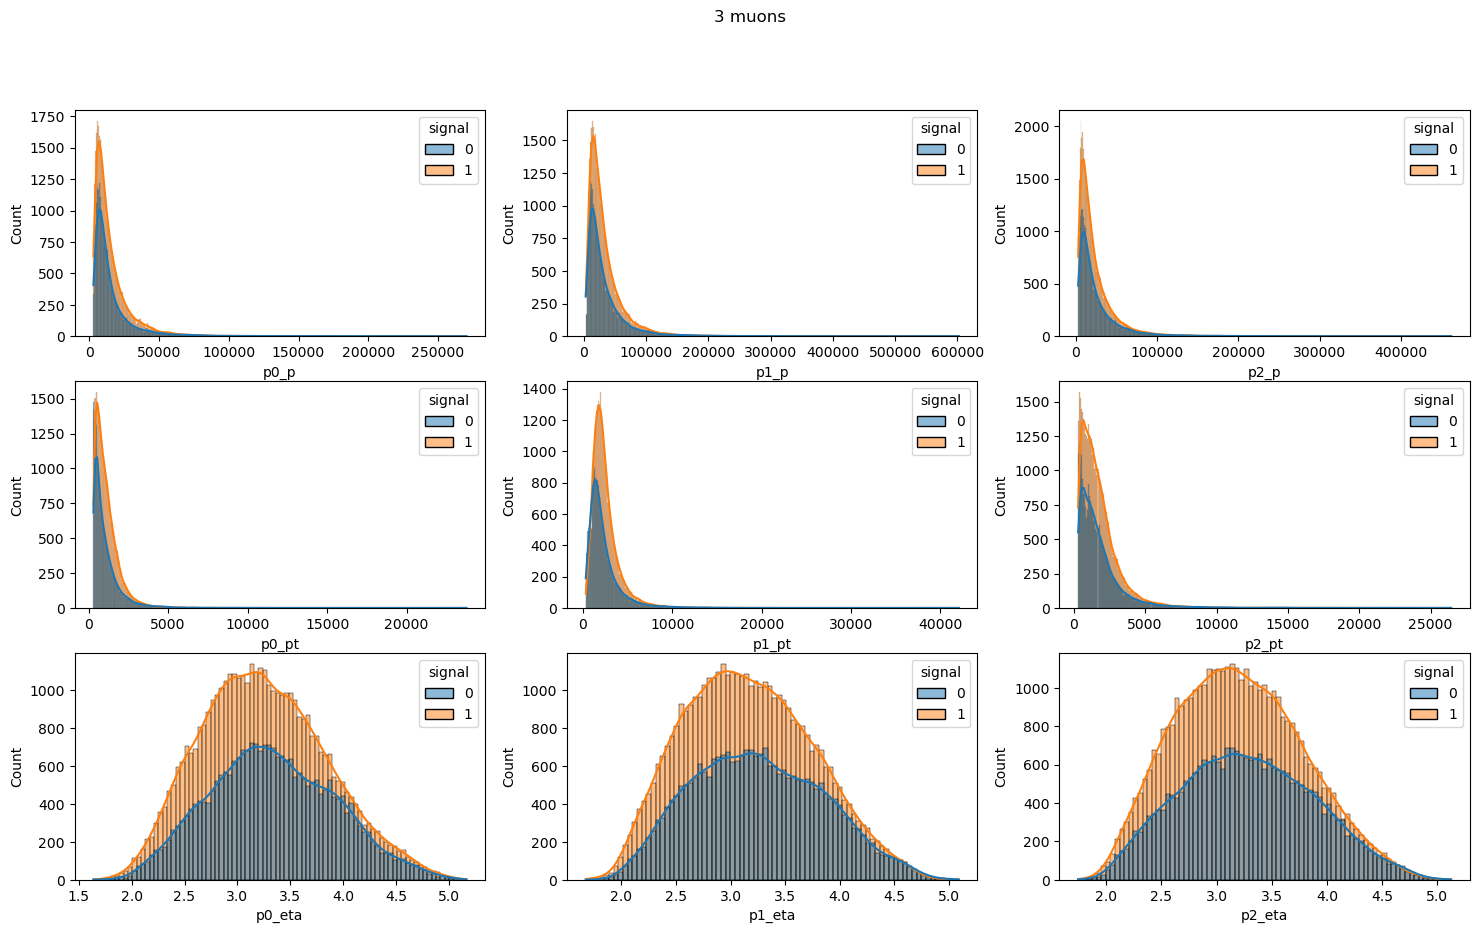

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(18, 10))
fig.suptitle('3 muons')
sns.histplot(data=train, x="p0_p",kde=True, hue = "signal", ax=axs[0, 0])
sns.histplot(data=train, x="p1_p",kde=True, hue = "signal", ax=axs[0, 1])
sns.histplot(data=train, x="p2_p",kde=True, hue = "signal", ax=axs[0, 2])
sns.histplot(data=train, x="p0_pt",kde=True, hue = "signal", ax=axs[1, 0])
sns.histplot(data=train, x="p1_pt",kde=True, hue = "signal", ax=axs[1, 1] )
sns.histplot(data=train, x="p2_pt",kde=True, hue = "signal", ax=axs[1, 2])
sns.histplot(data=train, x="p0_eta",kde=True, hue = "signal", ax=axs[2, 0])
sns.histplot(data=train, x="p1_eta",kde=True, hue = "signal", ax=axs[2, 1])
sns.histplot(data=train, x="p2_eta",kde=True, hue = "signal", ax=axs[2, 2])

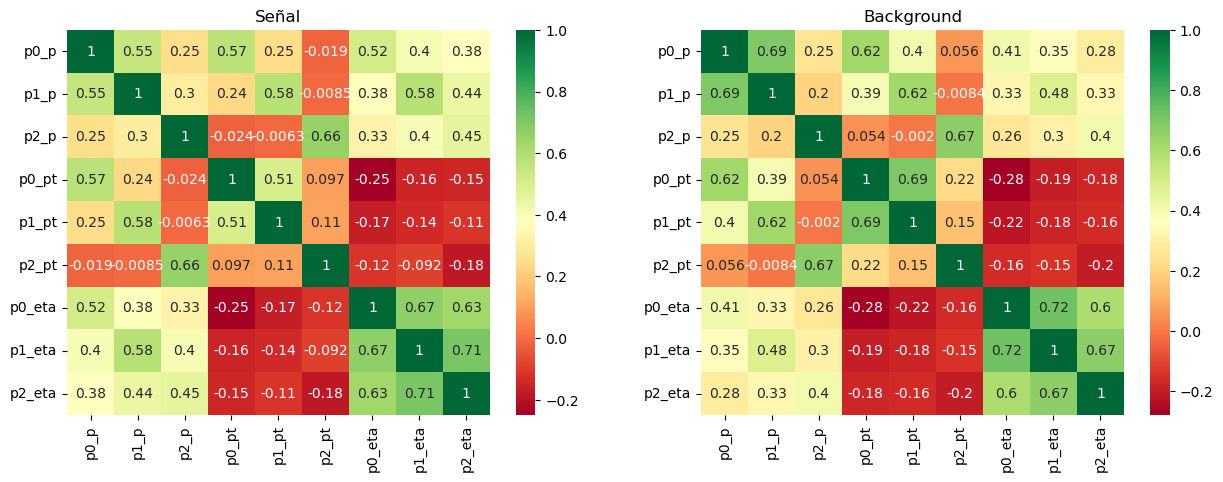

In [11]:
subset_mu_señal = señal[["p0_p", "p1_p", "p2_p", "p0_pt" , "p1_pt" , "p2_pt", "p0_eta" , "p1_eta","p2_eta" ]]
subset_mu_background = background[["p0_p", "p1_p", "p2_p", "p0_pt" , "p1_pt" , "p2_pt", "p0_eta" , "p1_eta","p2_eta" ]]
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Señal")
train_corr(subset_mu_señal)
plt.subplot(1,2,2)
plt.title("Background")
train_corr(subset_mu_background)

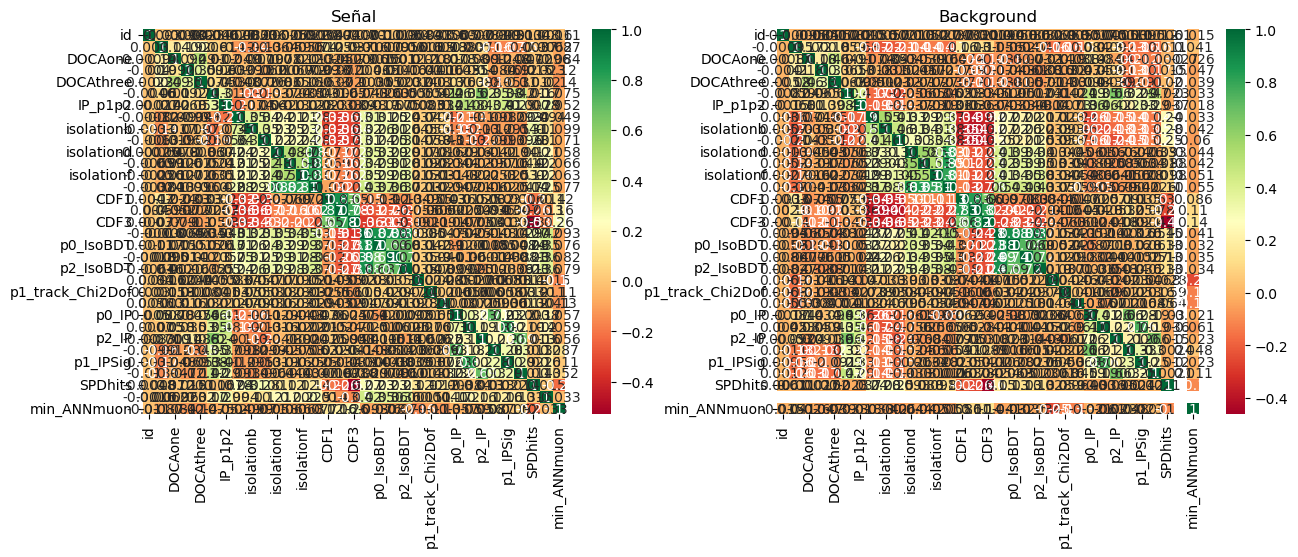

In [12]:
subset_detector_señal = señal.drop(["LifeTime", "FlightDistance", "dira", "mass" , "pt" , "IP", "IPSig" , "VertexChi2","signal", "p0_p", "p1_p", "p2_p", "p0_pt" , "p1_pt" , "p2_pt", "p0_eta" , "p1_eta","p2_eta" ], axis=1)
subset_detector_background = background.drop(["LifeTime", "FlightDistance", "dira", "mass" , "pt" , "IP", "IPSig" , "VertexChi2","signal", "p0_p", "p1_p", "p2_p", "p0_pt" , "p1_pt" , "p2_pt", "p0_eta" , "p1_eta","p2_eta" ], axis=1)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Señal")
train_corr(subset_detector_señal)
plt.subplot(1,2,2)
plt.title("Background")
train_corr(subset_detector_background)

# Signal and background corralations (tau)


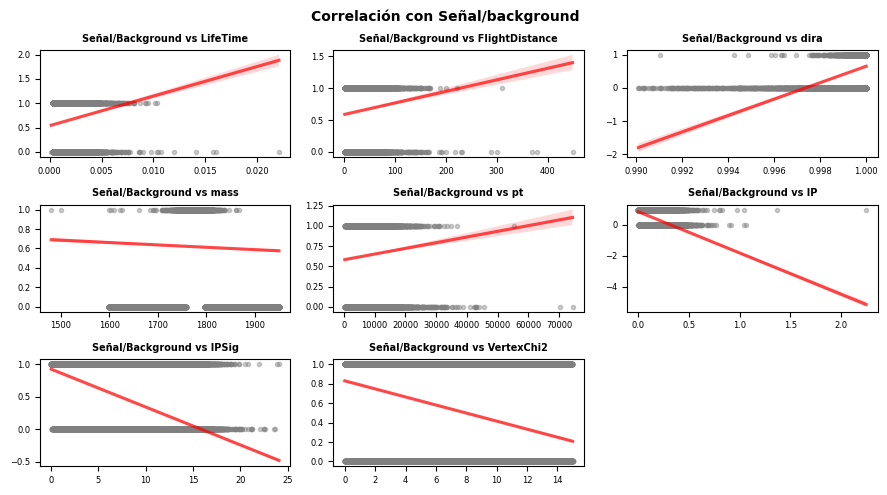

In [13]:
# Variable numérica
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas = subset_tau.select_dtypes(include=['float64', 'int']).columns
columnas = columnas.drop('signal') # objetivo

for i, colum in enumerate(columnas):
    sns.regplot(
        x           = subset_tau[colum],
        y           = subset_tau['signal'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"Señal/Background vs {colum}", fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in [8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con Señal/background', fontsize = 10, fontweight = "bold");

In [14]:
subset_tau.isnull().any().any()

False

# Variable selection (tau)

1. Target: y
2. Feature: x
Signal and background separation

In [15]:
x = subset_tau['signal']
k = 4  # número de atributos a seleccionar
entrenar = subset_tau.drop(['signal'], axis=1)
columnas = list(entrenar.columns.values)
seleccionadas = SelectKBest(f_classif, k=k).fit(entrenar, x)
atrib = seleccionadas.get_support()
atributos = [columnas[i] for i in list(atrib.nonzero()[0])]
atributos

['dira', 'IP', 'IPSig', 'VertexChi2']

# Variable selection (dataset)

In [16]:
x_all = train['signal'] 
entrenar_all = train.drop(['signal'], axis=1)
columnas_all = list(entrenar_all.columns.values) 
modelo_all = ExtraTreesClassifier()
erec_all = RFE(modelo_all)  
erec_all = erec_all.fit(entrenar_all, x_all)

In [17]:
atrib_all = erec_all.support_
atributos_all = [columnas_all[i] for i in list(atrib_all.nonzero()[0])]
atributos_all

['LifeTime',
 'dira',
 'IP',
 'IPSig',
 'VertexChi2',
 'DOCAone',
 'isolationa',
 'isolationd',
 'isolatione',
 'isolationf',
 'iso',
 'CDF2',
 'CDF3',
 'ISO_SumBDT',
 'p0_IsoBDT',
 'p1_IsoBDT',
 'p2_IsoBDT',
 'p0_track_Chi2Dof',
 'p1_track_Chi2Dof',
 'p0_IP',
 'p0_IPSig',
 'SPDhits',
 'production',
 'mass',
 'min_ANNmuon']

In [18]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
X_train = sc.fit_transform(entrenar_all)

pca = PCA(n_components = 4)
X_train = pca.fit_transform(entrenar_all)


In [19]:
# Importancia de atributos.
modelo_all.fit(entrenar_all, x_all)
modelo_all.feature_importances_[:24]

array([0.00037334, 0.0014923 , 0.00652718, 0.00060207, 0.00050307,
       0.01330144, 0.04684917, 0.01325016, 0.00127839, 0.00085894,
       0.00095687, 0.00106006, 0.00068223, 0.00127835, 0.00284148,
       0.00079674, 0.00104007, 0.00639999, 0.00594545, 0.00500859,
       0.00743883, 0.00051607, 0.00336064, 0.00111235])

# Fit data (tau)

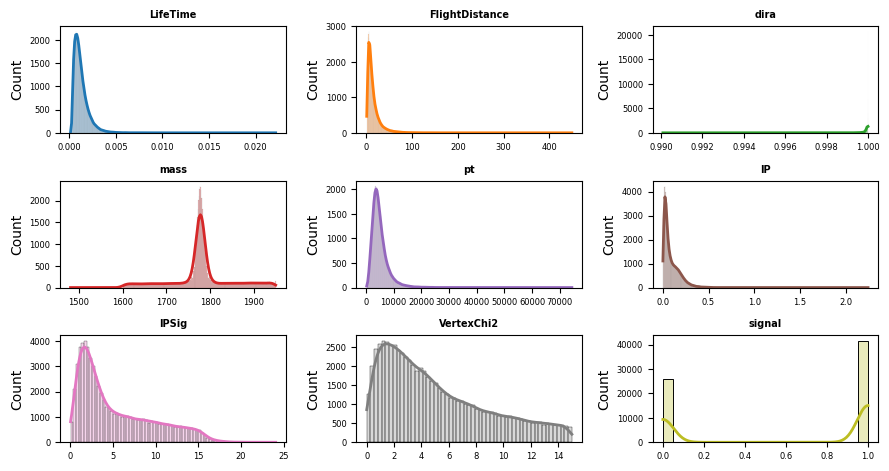

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 5))
axes = axes.flat
for i, colum in enumerate(subset_tau):
    sns.histplot(
        data     = subset_tau,
        x        = colum,
        stat     = "count",
        kde      = True,
        color    = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws = {'linewidth': 2},
        alpha    = 0.3,
        ax       = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    fig.tight_layout()
plt.subplots_adjust(top = 0.9)


# Fit Lifetime

In [21]:
# 80 distribuciones
distribuciones = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']
# Atributo
fitter = Fitter(train.LifeTime, distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=10, plot=False)

Fitting 9 distributions: 100%|██████████| 9/9 [00:01<00:00,  4.60it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,3.477420e+04,2804.148872,-44813.195929,inf,0.034444,4.587441e-70
logistic,2.625078e+05,3653.620471,91716.532452,inf,0.106182,0.000000e+00
cauchy,2.640252e+05,-147.783383,92105.911050,inf,0.151834,0.000000e+00
norm,4.096268e+05,21490.733770,121775.307696,inf,0.117517,0.000000e+00
expon,8.313468e+05,623.091775,169589.363779,inf,0.191323,0.000000e+00
powerlaw,1.607844e+06,-662.211908,214158.588176,inf,0.440519,0.000000e+00
gamma,1.861200e+06,-467.524154,224043.449310,inf,0.533343,0.000000e+00
chi2,1.896857e+06,-440.576259,225325.396794,inf,0.543236,0.000000e+00
exponpow,1.900290e+06,-427.219617,225447.556150,inf,0.556085,0.000000e+00


# ML model

In [22]:
dataset = train[['LifeTime','signal']]
dataset

,LifeTime,signal
0,0.001578,0
1,0.000988,0
2,0.000877,0
3,0.000854,0
4,0.001129,0
...,...,...
67548,0.002119,1
67549,0.002150,1
67550,0.000969,1
67551,0.001296,1


In [23]:
#Arreglo de numpy
x = dataset.iloc[:, :-1].values
#Dependiente            
y = dataset.iloc[:, 1].values

## Train and test datasets

In [24]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(x, y, test_size = 1/3, random_state=0)

## LinearRegression

m = [63.23114287], b = 0.5348229587928334
Mean squared error: 0.23
Coefficient of determination: 0.01


Text(0, 0.5, 'Salarios')

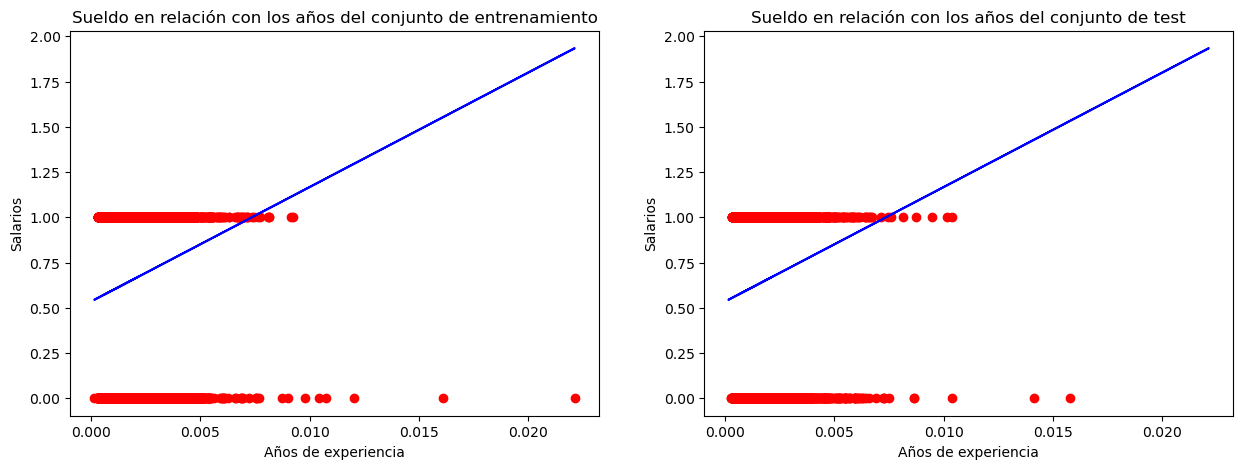

In [25]:
regresion_lineal = LinearRegression() # crear lel objeto de Regresión Linear
regresion_lineal.fit(x_train, y_train)
y_pred = regresion_lineal.predict(x_test)
# The coefficients
print('m = ' + str(regresion_lineal.coef_) + ', b = ' + str(regresion_lineal.intercept_)) 
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(x_train, y_train, color="red",label='Sample data')
plt.plot(x_train, regresion_lineal.predict(x_train), color="blue",label='Regression model')
plt.title("Sueldo en relación con los años del conjunto de entrenamiento")
plt.xlabel("Años de experiencia")
plt.ylabel("Salarios")

plt.subplot(1,2,2)
plt.scatter(x_test, y_test, color="red")
plt.plot(x_train, regresion_lineal.predict(x_train), color="blue")
plt.title("Sueldo en relación con los años del conjunto de test")
plt.xlabel("Años de experiencia")
plt.ylabel("Salarios")

In [26]:
train_cut = train.drop(train[train.min_ANNmuon <= 0.4].index)
x = train_cut.drop(['min_ANNmuon', 'mass', 'production', 'signal', 'id', 'SPDhits'], axis = 1)
y = train_cut['signal']
#x = x.reshape(-1,1)
pd.set_option('display.max_columns', None)
x.head()
regresion_lineal = LinearRegression()
regresion_lineal.fit(x, y)

LinearRegression()

In [27]:
print('m = ' + str(regresion_lineal.coef_) + ', b = ' + str(regresion_lineal.intercept_)) 
print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

m = [ 8.45512303e+01  8.41906255e+01  5.99935973e-04 -6.24998132e-02
 -3.02716084e-01 -3.30416771e-02 -1.71622057e-02  2.04144737e-04
 -1.24673596e-01 -1.49339670e-01 -1.46170499e-01  1.19682782e-01
  8.70264204e-02 -8.24571939e-03  1.60922741e-03  3.30469324e-03
 -8.58427167e-03 -1.91987311e-02 -8.15213129e-03 -3.59351343e-02
  8.76346552e-02  6.94828655e-02 -1.07459478e-01 -4.68413459e-02
  2.85241574e-03  2.21031017e-02  2.61920688e-02 -9.66364300e-02
 -3.88854628e-02 -3.48710294e-02 -2.67292632e-02 -5.12157686e-02
 -7.28996488e-02  1.02787528e-03  9.71087273e-04 -1.45357083e-03
 -2.44375252e-04 -2.09160218e-04 -2.25786340e-04  8.94432986e-07
 -8.65764136e-08  4.44093345e-07 -3.78166536e-02 -5.38924975e-03
 -3.37415765e-02], b = -82.68908407094494


ValueError: Found input variables with inconsistent numbers of samples: [38012, 22518]

## DecisionTree

In [28]:
model = DecisionTreeRegressor(random_state=1)
model.fit(x, y)

DecisionTreeRegressor(random_state=1)

In [29]:
print(x.head())
print("The predictions are")
print(model.predict(x.head()))

    LifeTime      dira  FlightDistance  FlightDistanceError        IP  \
10  0.000601  0.999767        3.693194             0.201345  0.083370   
12  0.001886  0.999981       24.559412             0.649219  0.144859   
16  0.000409  0.999975        3.712895             0.223451  0.026139   
22  0.001488  0.999848        5.565922             0.227599  0.098606   
24  0.000954  0.999909        4.507031             0.365968  0.052416   

       IPSig  VertexChi2           pt   DOCAone   DOCAtwo  DOCAthree  \
10  6.727314    8.714045  5710.048828  0.026324  0.023561   0.015320   
12  9.159951    2.777078  3053.174316  0.073959  0.005948   0.029902   
16  2.152818    8.165641  5545.256348  0.044176  0.038405   0.021901   
22  5.290829    2.304871  1759.276123  0.014047  0.098456   0.080705   
24  1.959472   14.788579  1581.057739  0.018213  0.556096   0.657791   

     IP_p0p2   IP_p1p2  isolationa  isolationb  isolationc  isolationd  \
10  0.123138  0.094504           2           7        

## Validation

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
train_x, val_x, train_y, val_y = train_test_split(x, y, random_state = 0)
# Define model
model = DecisionTreeRegressor()
# Fit model
model.fit(train_x, train_y)

# get predicted prices on validation data
val_predictions = model.predict(val_x)
print(val_predictions)
val_mean = mean_absolute_error(val_y, val_predictions)

print(val_mean)

[1. 1. 1. ... 1. 1. 1.]
0.1712090918657266
